---
# INITIALISATION
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/AMAS/ML/churn_prediction.csv")

In [ ]:
data.head()

In [ ]:
#Afficher les 5 derniéres lignes
data.tail()

In [ ]:
#Dimensions du dataframe: sortie (nombre de lignes, nombre de colonnes)
data.shape

In [ ]:
#Afficher tous les noms des colonnes présentes dans la base
data.columns

---
## IDENTIFICATION DES VARIABLES
----

In [ ]:
# Afficher les types de données de chaque colonne
data.dtypes

In [ ]:
data.memory_usage(deep = True)

In [ ]:
print(data.memory_usage(deep = True).sum())

# Conversion des types des variables

In [ ]:
# Convertissons les données ci-dessous en categorielles
data['churn'] = data['churn'].astype('category')
data['branch_code'] = data['branch_code'].astype('category')
data['customer_nw_category'] = data['customer_nw_category'].astype('category')
data['gender'] = data['gender'].astype('category')
data['occupation'] = data['occupation'].astype('category')

# Remplacer pour le moments les valeurs manquantes par 0
data['dependents'] = data['dependents'].fillna(0)
# Convertir les types des données
data['dependents'] = data['dependents'].astype('int64')
data['city'] = data['city'].astype('category')

In [ ]:
# Conversion de last_transaction en datetime en utilisante la fonction DateTimeIndex de pandas
date = pd.DatetimeIndex(data['last_transaction'])
# Extraire le jour, la semaine, le mois et l'année de la transaction
data['day_trans'] = date.dayofyear
data['week_trans'] = date.weekofyear
data['month_trans'] = date.month
data['day_week'] = date.dayofweek

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  """


---
# ANALYSE UNIVARIEE
---

---
### VARIABLES CONTINUES
---

In [ ]:
#on selectionne toutes les colonnes numeriques en utilisant la fonction select_dtypes
colonnes_num = data.select_dtypes(include=['int64','float64']).columns

In [ ]:
colonnes_num

In [ ]:
# Regroupement des variables par groupe
details_clients = ['vintage', 'age', 'dependents']
details_mois_courant = ['current_balance','current_month_credit','current_month_debit','current_month_balance']
details_mois_passe = ['previous_month_end_balance','previous_month_credit', 'previous_month_debit']
details_trimestre_passe = ['average_monthly_balance_prevQ','average_monthly_balance_prevQ2']
date_transactions = ['day_trans','week_trans', 'month_trans', 'day_week']


In [ ]:
def AVU_numerique(data,group_variables):
  nvars = len(group_variables)
  plt.figure(figsize=(7*nvars, 3), dpi = 100)
  for i,j in enumerate(group_variables):
    # Les paramétres descriptifs
    mini = data[j].min()
    maxi = data[j].max()
    ran = maxi - mini
    moy = data[j].mean()
    mediane =  data[j].median()
    ecart = data[j].std()
    sk = data[j].skew()
    kurt = data[j].kurtosis()
    points = (moy - ecart, moy + ecart)


    plt.subplot(1,nvars,i+1)
    sns.kdeplot(x = data[j],shade = True)
    sns.lineplot(x = points,y = [0,0],color = 'red')
    sns.scatterplot(x = [moy],y = [0],label = 'moyenne',color = 'blue')
    sns.scatterplot(x = [mediane],y = [0],label = 'mediane',color = 'green')
    sns.scatterplot(x = [mini,maxi],y = [0,0],label = 'mini/maxi',color = 'cyan')

    plt.xlabel('{}'.format(j),fontsize = 20)
    plt.ylabel("Densite")
    plt.title('Niveau 1 dispersion = {}; kurt = {};\nsk = {}; range = {}\nmoy = {}; mediane = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(sk,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(moy,2),
                                                                                                   round(mediane,2)))



In [ ]:
AVU_numerique(data,details_clients)

** RESUME DONNEES CLIENTS**

AGES
* La plupart des clients ont entre 30 et 66 ans
* Moyenne et mediane assez proches
* Semble assez symétrique avec un skew de 0.33 mais avec un leger biais vers les jeuns
* Kurtosis < 0 donc une faible presence de valeurs extrêmes. On doit s'interesser à cette tranche 85-100 qui fait un bond assez remarquable

VINTAGE

* Moyenne et mediane assez proches
* La plupart des clients est à 1800 et 2300 jours dans la banque
* Skew de -1.39 donc oblique à gauche et kurt eleve donc forte presence de valeurs extrêmes
* Question: la plupart des clients sont au moins à 1000 jours avec la banque. Il serait interessant de voir ceux partent.

DEPENDANTS

* La plupart des clients sont entre 0 et 1 dependants
* Moyenne  supérieure à la mediane
* 50% de clients n'ont pas de dépendants
* Oblique à droite avec une forte probabilité de presence de valeurs extrêmes

In [ ]:
AVU_numerique(data,details_mois_courant)

** RESUME DONNEES MOIS COURANTS**

* Les moyennes sont largement supérieures aux médianes
* Medianes faibles pour toutes les courbes donc 50% des clients font peu de transactions dans cette banque.
* Toutes les courbes sont obliques à droite et presentent  des valeurs extrêmes. Nous devons les visualiser sans ces valeurs extrêmes pour mieux voir leurs allures

In [ ]:
# Enlevons les valeurs extrêmes
# On elimine les points qui sont à un niveau donné de dispersion ( 1, 2,3)
niveau = 1

cm_data = data[details_mois_courant]

# Filtrons les données

cm_data = cm_data[(cm_data['current_balance'] >  cm_data['current_balance'].mean() - niveau *cm_data['current_balance'].std()) & (cm_data['current_balance'] <  cm_data['current_balance'].mean() + niveau *cm_data['current_balance'].std())]
cm_data = cm_data[cm_data['current_month_credit'] <  cm_data['current_month_credit'].mean() + niveau *cm_data['current_month_credit'].std()]
cm_data = cm_data[cm_data['current_month_debit'] <  cm_data['current_month_debit'].mean() + niveau *cm_data['current_month_debit'].std()]
cm_data = cm_data[cm_data['current_month_balance'] <  cm_data['current_month_balance'].mean() + niveau *cm_data['current_month_balance'].std()]

# Nombre de points filtrés

len(data), len(cm_data)

In [ ]:
AVU_numerique(cm_data,details_mois_courant)

* **Même aprés suppression des valeurs extrêmes le skewness demeure**

* **Il faut voir pourquoi il y a peu de transactions dans les comptes avec un solde élevé au courant du mois**
**Quelques questions à étudier**
1. **Existe-t-il un trait/une relation commune entre les clients qui effectuent des opérations de crédit/débit élevées ?**
2. **Les clients qui effectuent un grand nombre de transactions le font-ils tous les mois ?**

In [ ]:
AVU_numerique(data,details_mois_passe)

**Resume Mois passé**

Nous observons les mêmes tendances que pour le mois courant. La plupart des clients effectuent peu de transactions.

In [ ]:
AVU_numerique(data,details_trimestre_passe)

**Resume trimestre passé**

La tendance générale suit toujours, il est crucial de découvrir s'il existe un trait commun entre les clients effectuant un nombre élevé de transactions. Qu'est-ce qu'ils font à travers leurs transactions?

In [ ]:
AVU_numerique(data,date_transactions)

**Resume last transaction**

* La plupart des transactions ont été effectuée durant les 60 derniers jours.

* Des transactions ont été effectuées il y a plus d'un an

* Tout le reste confirme ce qui s'est passé pour les jours de transaction.




---
### VARIABLES CATEGORIELLES
---

---
#### EXTRACTION DES VARIABLES CATEGORIELLES
---

In [ ]:
data.select_dtypes(include = ['category']).dtypes

**Quelques fonctions utiles**
* value_counts() permet de compter les effectifs des differentes classes
* value_counts(normalize = True) permet de compter et normaliser les effectifs des differentes classes
* unique() permet d'avoir les categories

**regroupement des données**
* Details clients: gender, occupation,  customer_nw_category
* Bank info: branch_code, city
* churn

In [ ]:
data['gender'].value_counts(normalize = True)

In [ ]:
data['gender'].nunique()

In [ ]:
data['occupation'].value_counts(normalize=True)

In [ ]:
data['gender'].unique()

In [ ]:
data['occupation'].unique()

In [ ]:
sns.countplot(x=data['gender'])

In [ ]:
sns.barplot(x=data['occupation'].value_counts(normalize=True).index, y=data['occupation'].value_counts(normalize=True))

In [ ]:
cat_details_client = ['gender', 'occupation', 'customer_nw_category']
cat_bank_info = ['branch_code', 'city']
cat_churn = ['churn']

In [ ]:
def AVU_cat(data,group_variables):
  nvars = len(group_variables)
  plt.figure(figsize=(7*nvars, 5), dpi = 100)
  for i,j in enumerate(group_variables):
    # Les paramétres descriptifs
    mode = data[j].mode()
    counter = data[j].value_counts(normalize = True,dropna = True)
    n_uni = data[j].nunique()

    plt.subplot(1,nvars,i+1)
    sns.barplot(x = counter.index,y = counter,order = counter.index, data = data)


    plt.xlabel('{}'.format(j),fontsize = 20)
    plt.ylabel("Distribution")
    plt.title(' Categories: {}\n Effectif par categories:\n {} '.format(n_uni,counter))

In [ ]:
AVU_cat(data,cat_details_client)

**Resume**

* Genre: les hommes sont supérieurs aux femmes
* Occupation: la majorité des clients font dans l'auto-emploi. Peu de compagnies
* Categorie: 35% sont dans la troisiéme categorie. Seuls 13% se trouvent dans la categorie des revenus élevées

**Questions**
* Est-ce que les clients de la categorie des revenus élevés sont à l'origine des volumes de transactions élevées?
* Quelles sont les categories d'emploi qui sont à l'origine des valeurs extrêmes dans les transactions?

In [ ]:
AVU_cat(data,cat_bank_info)

**Resume**
* Il y a des agences et des villes trés utilisées, d'autres  non.

**Questions**

* Est-ce que ces agences et villes populaires peuvent être à l'origine de l'etirement et des valeurs extrêmes dans les variables de credit et debit?

* Est-ce que les clients des agences non populaires ont tendance à quitter ?

In [ ]:
AVU_cat(data,cat_churn)

**Resume**

* 18% des clients se désabonnent

---
### VALEURS MANQUANTES
---

In [ ]:
data.isnull().sum()

In [ ]:
data.isna().sum()

**Éléments à étudier plus bas :**
* Genre : les clients dont les valeurs de genre sont manquantes ont-ils des comportements communs ?
   * churn : les valeurs manquantes ont-elles une relation avec le churn ?

* dependents :
  * Les valeurs manquantes peuvent être similaires à zéro personne à charge
  * churn : les valeurs manquantes ont-elles une relation avec le churn ?

* Profession:
  * Les valeurs manquantes sont-elles pour toute autre profession
  * ont-ils une relation avec le taux de churn ?

* city:
   * les villes respectives peuvent être trouvées en utilisant branch_code

* last_transaction :
   * La vérification de leur activité du mois précédent, du mois en cours et du trimestre précédent peut donner un aperçu de leur dernière transaction.

* Pour presque tout ce qui précède :

   * vintage : il peut s'agir d'erreurs d'enregistrement de la période d'adhésion
   * branch_code : peut être une erreur d'enregistrement de certaines succursales

---
### VALEURS ABERRANTES
---

In [ ]:
def UVA_outlier(data, var_group, include_outlier = True):
  '''

  Analyse valeurs aberrantes :
   prend un groupe de variables (INTEGER et FLOAT) et trace/imprime boxplot et descriptions\n
   Exécute une boucle : calcule tous les descriptifs de la i(ième) variable et les imprime \n\n

   data : dataframe des données\n
   var_group : {liste} type Groupe de variables continues\n
   include_outlier : {bool} s'il faut inclure ou non les valeurs aberrantes, par défaut = True\n
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 100)

  #Pour chaque variable
  for i,j in enumerate(var_group):

    # calcul des variables  descriptives
    quant25 = data[j].quantile(0.25)
    quant75 = data[j].quantile(0.75)
    IIQ = quant75 - quant25
    med = data[j].median()
    whis_low = quant25-(1.5*IIQ)
    whis_high = quant75+(1.5*IIQ)

    # Calcule du nombre de valeurs aberrantes
    outlier_high = len(data[j][data[j]>whis_high])
    outlier_low = len(data[j][data[j]<whis_low])

    if include_outlier == True:
      print(include_outlier)
      #Representation des boxplots
      plt.subplot(1,size,i+1)
      sns.boxplot(data=data[j], orient="h")
      plt.ylabel('{}'.format(j))
      plt.title('Avec Outliers\nIIQ = {}; MedianE = {} \n 1st,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IIQ,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

    else:
      # remplacer les outliers par les min/max du whisker
      data2 = data[var_group][:]
      data2[j][data2[j]>whis_high] = whis_high+1
      data2[j][data2[j]<whis_low] = whis_low-1

      # Graphiques sans outliers
      plt.subplot(1,size,i+1)
      sns.boxplot(data=data2[j], orient="h")
      plt.ylabel('{}'.format(j))
      plt.title('Sans Outliers\nIIQ = {}; Median = {} \n 1st,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IIQ,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

In [ ]:
UVA_outlier(data, details_mois_courant)

In [ ]:
UVA_outlier(data, details_mois_courant,include_outlier = False)

In [ ]:
UVA_outlier(data, details_mois_passe)

In [ ]:
UVA_outlier(data, details_mois_passe,False)

**Resume:**
* Si nous examinons les tracés correspondants dans les boxplots ci-dessus, il semble y avoir une forte relation entre les tracés correspondants des variables du mois précédent et celle du mois courant.

* Les valeurs aberrantes sont significatives en nombre et très similaires en nombre entre les variables correspondantes. Ce qui indique un comportement inhérent des valeurs aberrantes à découvrir.

In [ ]:
UVA_outlier(data, details_trimestre_passe)

In [ ]:
UVA_outlier(data, details_trimestre_passe,False)

## Directions à suivre aprés l'analyse univariée
1. La variable customer_id peut être supprimée.
2. Existe-t-il une relation  entre les clients qui effectuent des opérations de crédit/débit élevées ?
    * customer_nw_category pourrait expliquer cela.
    * Occupation = L'entreprise pourrait les expliquer
    * les villes populaires pourraient expliquer cela
4. Les clients dont la dernière transaction remonte à 6 mois, ont-ils tous abandonné ?
5. Possibilité que les villes et les succursales avec très peu de comptes entrainent un desabonnement.

---
# ANALYSE BIVARIÉE
---

---
## NUMERIQUE-NUMERIQUE
---

In [ ]:
# isoler les variables numeriques
numerical = data.select_dtypes(include=['int64','float64','Int64'])[:]
numerical.dtypes

## Matrice de correlation

In [ ]:
# calcul des correlations
correlation = numerical.dropna().corr()
correlation

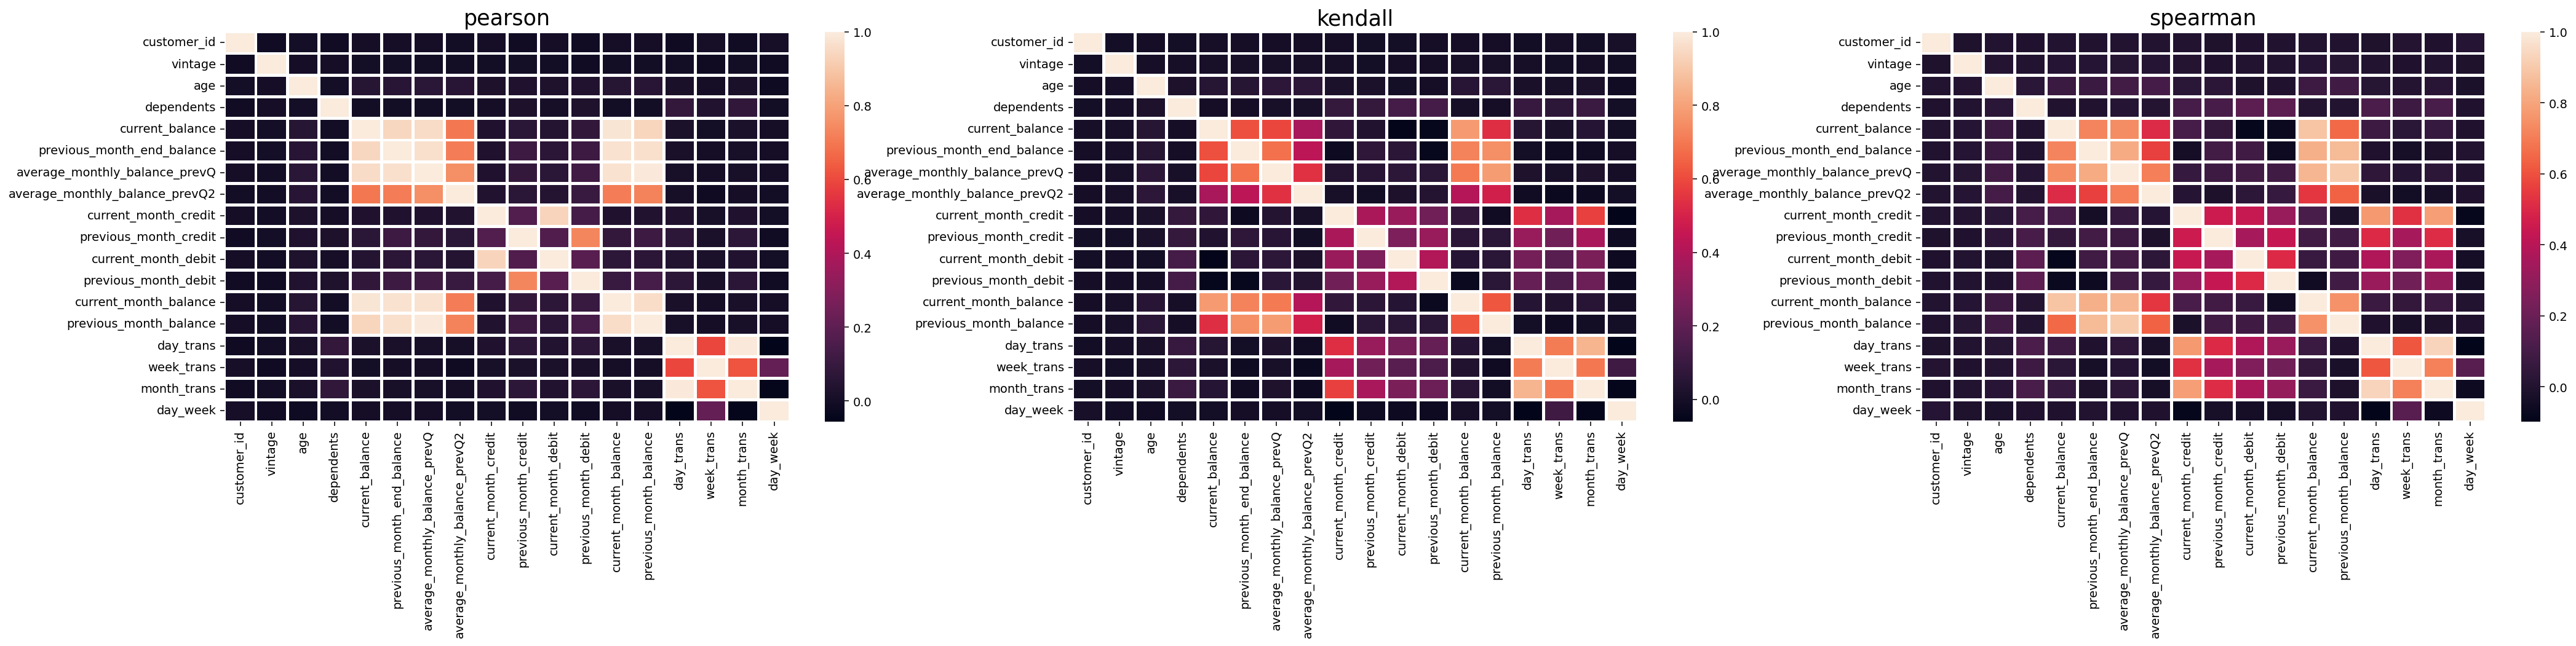

In [ ]:
# Dessiner les heatmaps pour tous les coefs de correlation et toutes les variables numeriques
plt.figure(figsize=(36,6), dpi=140)
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(1,3,j+1)
  correlation = numerical.dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)

* La corrélation de Kendall et Spearman semble avoir un schéma très similaire entre eux, à l'exception de la légère variation de l'ampleur de la corrélation.
* Trop de variables avec une corrélation insignifiante.
* Les corrélations majeures se situent entre les variables de transaction et les variables de solde.

In [ ]:
# ectraction des informations de transction des mois courants et passés
var = []
var.extend(details_mois_passe)
var.extend(details_mois_courant)
var.extend(details_trimestre_passe)

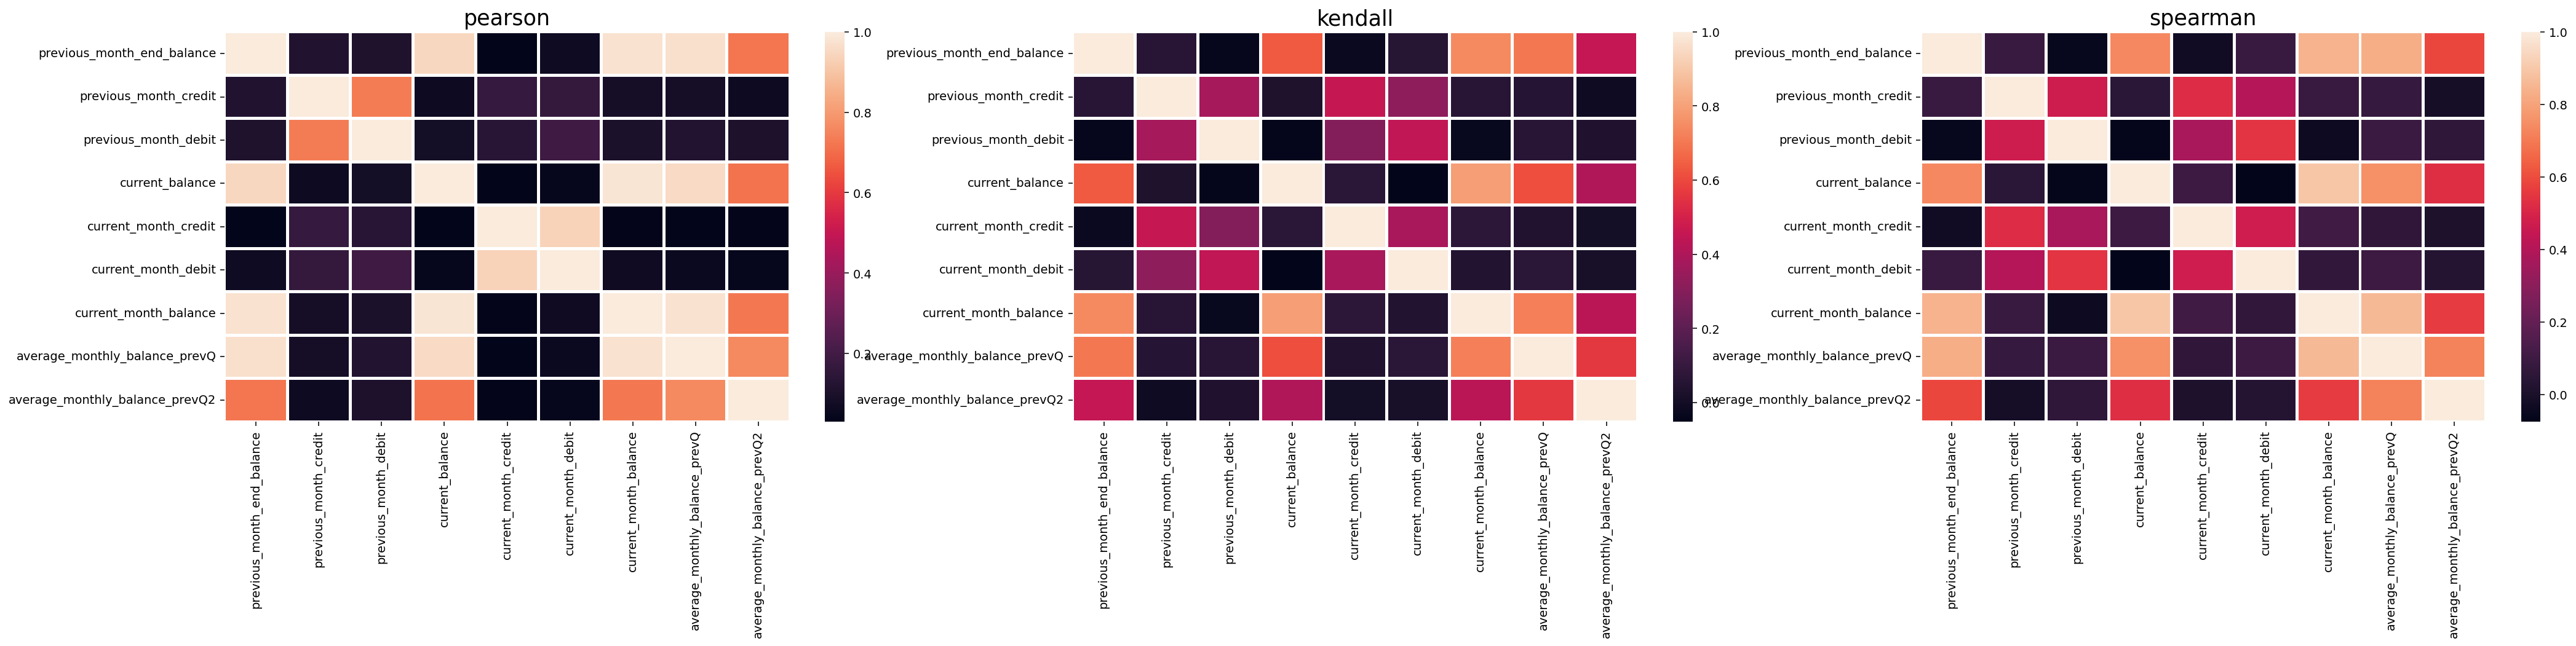

In [ ]:
# Dessiner les heatmaps pour tous les coefs de correlation et les variables de transaction
plt.figure(figsize=(36,6), dpi=140)
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(1,3,j+1)
  correlation = numerical[var].dropna().corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)



**Inférences :**


1. Les variables de transaction comme le crédit/débit ont une forte corrélation entre elles.
2. Les variables de solde ont une forte corrélation entre elles.
3. Les variables de transaction comme le crédit/débit ont une corrélation insignifiante ou nulle avec les variables de solde.

In [ ]:
# Groupage des variables en transactions et soldes
transactions = ['current_month_credit','current_month_debit','previous_month_credit','previous_month_debit']
solde = ['previous_month_end_balance','previous_month_balance','current_balance','current_month_balance']

In [ ]:
# scatter plot pour les variables  transactionnelles
plt.figure(dpi=140)
#sns.pairplot(numerical[transactions])

<Figure size 840x560 with 0 Axes>

<Figure size 840x560 with 0 Axes>

In [ ]:
#Prenons les log des valeurs pour annuler les valeurs aberrantes
for column in var:
  mini=1
  if numerical[column].min()<0:
    mini =  abs(numerical[column].min()) + 1

  numerical[column] = [i+mini for i in numerical[column]]
  numerical[column] = numerical[column].map(lambda x : np.log(x))

<Figure size 840x560 with 0 Axes>

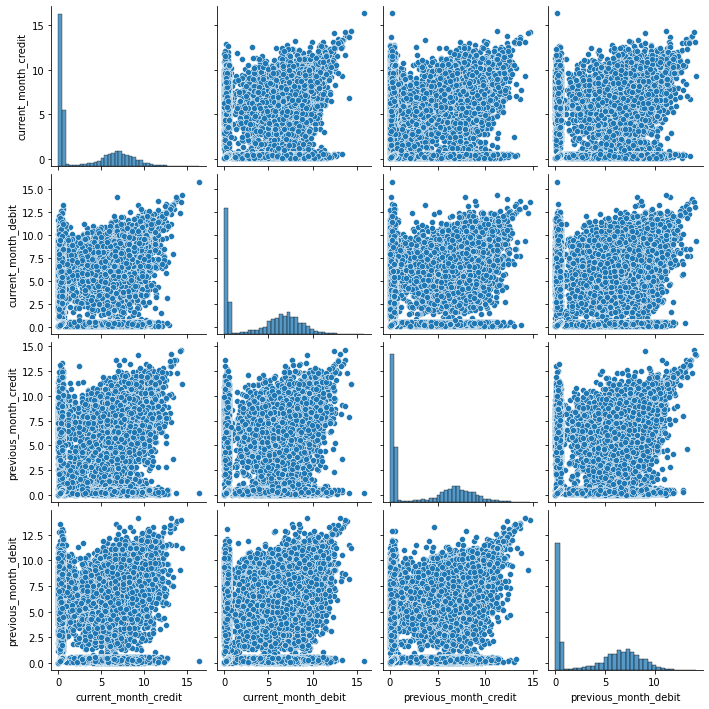

In [ ]:
# scatter plot pour les varaibles transactionnels
plt.figure(dpi=140)
sns.pairplot(numerical[transactions])

**Inférences**
1. Cela valide la forte corrélation entre les variables de transaction.
2. Cette corrélation élevée peut être utilisée pour le feature engineering au cours des prochaines étapes.

<Figure size 840x560 with 0 Axes>

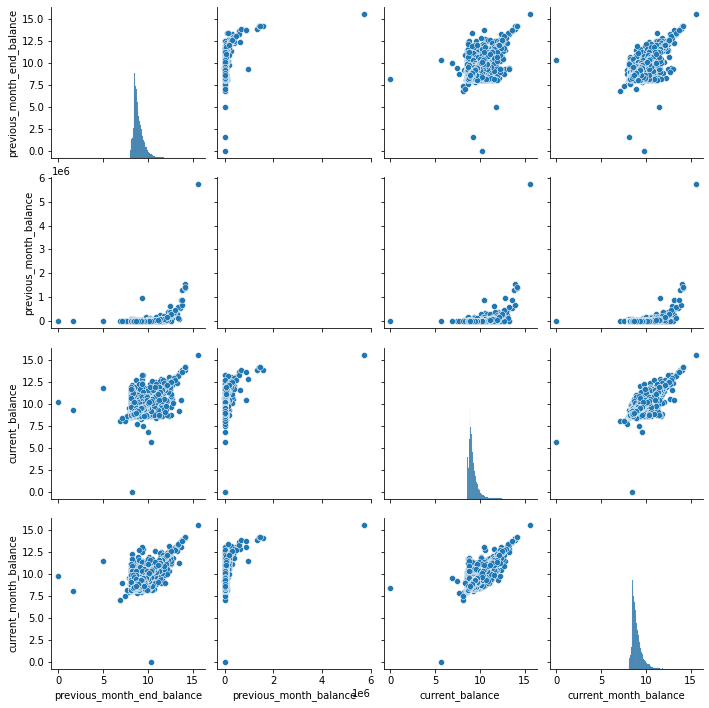

In [ ]:
# variables de soldes
plt.figure(dpi=140)
sns.pairplot(numerical[solde])

**Inférences**
1. Cela valide la forte corrélation entre les variables de solde.
2. Cette corrélation élevée peut être utilisée pour le feature engineering au cours des prochaines étapes.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


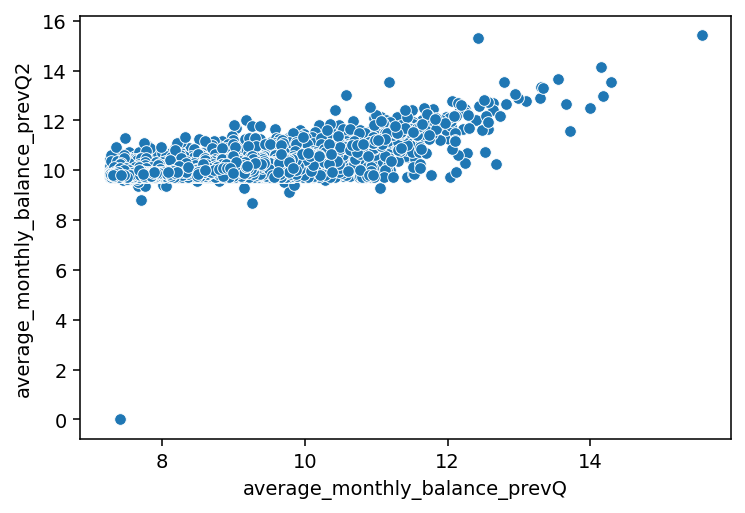

In [ ]:
# les trimestres passés
plt.figure(dpi=140)
sns.scatterplot(numerical['average_monthly_balance_prevQ'], numerical['average_monthly_balance_prevQ2'])

**Inférences**
1. Cela valide la forte corrélation entre les deux trimestres précédents
2. Cette corrélation élevée peut être utilisée pour le feature engineering au cours des prochaines étapes.

In [ ]:
data.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,day_trans,week_trans,month_trans,day_week
0,1,2101,66,Male,0,self_employed,187.0,2,755,1458.71,...,0.20,0.20,1458.71,1458.71,0,2019-05-21,141.0,21.0,5.0,1.0
1,2,2348,35,Male,0,self_employed,NaN,2,3214,5390.37,...,5486.27,100.56,6496.78,8787.61,0,2019-11-01,305.0,44.0,11.0,4.0
2,4,2194,31,Male,0,salaried,146.0,2,41,3913.16,...,6046.73,259.23,5006.28,5070.14,0,NaT,NaN,NaN,NaN,NaN
3,5,2329,90,NaN,0,self_employed,1020.0,2,582,2291.91,...,0.47,2143.33,2291.91,1669.79,1,2019-08-06,218.0,32.0,8.0,1.0
4,6,1579,42,Male,2,self_employed,1494.0,3,388,927.72,...,588.62,1538.06,1157.15,1677.16,1,2019-11-03,307.0,44.0,11.0,6.0


In [ ]:
from pickle import TRUE
data.drop(["customer_id","last_transaction", "day_trans", "week_trans", "month_trans", "day_week"], axis = 1, inplace = True)

In [ ]:
data.head()

,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,2101,66,Male,0,self_employed,187.0,2,755,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2348,35,Male,0,self_employed,NaN,2,3214,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,2194,31,Male,0,salaried,146.0,2,41,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,2329,90,NaN,0,self_employed,1020.0,2,582,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,1579,42,Male,2,self_employed,1494.0,3,388,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1
